# Cifar10 - Transferência de aprendizado

Utilizar rede já pré-treinada para o projeto de classificador do Cifar10 com poucos dados

In [2]:
import os
import sys
import numpy as np
import numpy.random as nr

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD, RMSprop

print('Keras ', keras.__version__)
% pwd
sys.path.append('../../lotufo/ia368z/src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

import matplotlib.pyplot as plot
%matplotlib inline

Using TensorFlow backend.


Keras  2.0.5


In [3]:
data = np.load('/etc/jupyterhub/ia368z_2s2017/datasets/cifar10-redux.npz')

In [4]:
X_train = data['X_train'].transpose((0,2,3,1))
y_train = data['y_train']
X_test = data['X_test'].transpose((0,2,3,1))
y_test = data['y_test']

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2000, 32, 32, 3), (2000,), (500, 32, 32, 3), (500,))

In [6]:
num_classes = 3
y_train = keras.utils.to_categorical(y_train-3, num_classes)
y_test_categorical = y_test-3
y_test = keras.utils.to_categorical(y_test-3, num_classes)

X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the X_train to validation

X_val = X_train[1500:]
y_val = y_train[1500:]
X_train = X_train[0:1499]
y_train = y_train[0:1499]

In [7]:
model_name = 'cifar-10'   # modelo da rede atual

def build_net():
    from keras.applications.vgg16 import VGG16
    
    print("[INFO] creating model...")
    #vgg = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    vgg = VGG16(include_top=False, weights='imagenet',classes=3,pooling="max")
    # build a classifier model and put on top of the convolutional model
    x = Dense(40, activation='relu', name='dense1',input_shape=(512,2))(vgg.output)
    x = Dropout(0.5)(x)
    x = Dense(120, activation='relu', name='dense2')(x)
    x = Dropout(0.2)(x)
    x = Dense(3, activation='softmax', name='dense3')(x)

    model = Model(inputs=vgg.input, outputs=x)
    
    # modelo da rede densa treinada no notebook anterior
    #top_model_name = 'models/cats_dogs_vgg.model'
    # Carrego os pesos treinados anteriormente
    #w1, b1, w2, b2 = load_model(top_model_name).get_weights()    
    # Coloco nas camadas densas finais da rede
    #model.layers[20].set_weights([w1, b1])
    #model.layers[22].set_weights([w2, b2])
    
    #model.get_layer('d1')
    
    # Torno não-treináveis as primeiras 15 camadas
    # da rede (os pesos não serão alterados)
    for layer in model.layers[:15]:
        layer.trainable = False
        
    return model

model = build_net()
model.summary()

[INFO] creating model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128

In [8]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network_generator(model, model_name, train_generator, validation_generator, 
                  train_steps=10, valid_steps=10, opt='rmsprop', loss='mse', metrics=[], 
                  nepochs=50, patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    # initialize the optimizer and model
    print("[INFO] compiling model...")
    model.compile(loss=loss, optimizer=opt, metrics=metrics)    
    
    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
        model.fit_generator(train_generator, steps_per_epoch=train_steps,
                            validation_data=validation_generator, validation_steps=valid_steps,
                            epochs=nepochs, verbose=vv, callbacks=[cb])
    except KeyboardInterrupt:
        pass

    model, histo = load_model_and_history(model_name)
    return model, cb

def train_network(model, model_name, train_data, val_data, 
                  train_steps=10, valid_steps=10, opt='rmsprop', loss='mse', metrics=[], 
                  nepochs=50, patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    # initialize the optimizer and model
    print("[INFO] compiling model...")
    model.compile(loss=loss, optimizer=opt, metrics=metrics)    
    
    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
        model.fit(train_data[0], train_data[1], validation_data=val_data,
                            epochs=nepochs, verbose=vv, callbacks=[cb])
    except KeyboardInterrupt:
        pass

    model, histo = load_model_and_history(model_name)
    return model, cb


def test_network(model_name, validation_generator, nb_validation_samples):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate_generator(validation_generator, nb_validation_samples)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


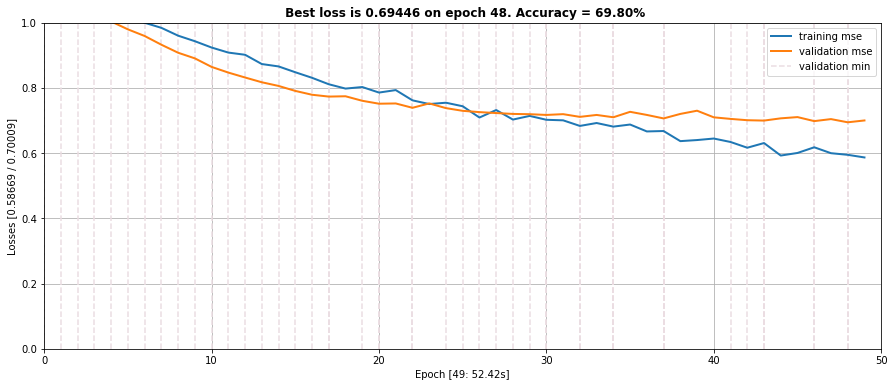

In [9]:
batch_size = 200

fit_params = {
    'train_steps':     1600 / batch_size,
    'valid_steps':     400 / batch_size,
    'opt':             SGD(lr=0.0001, momentum=0.9, nesterov=True), 
    'loss':            'categorical_crossentropy', 
    'metrics':         ['accuracy'],
    'nepochs':         50, 
    'patience':        15,
    'ploss':           1.0,
    'reset':           True,
}


train_network(model, model_name, (X_train, y_train), (X_val, y_val), **fit_params);

In [10]:
loss, accuracy = model.evaluate(X_test,y_test)
print(loss)
print(accuracy)

500/500 [==============================] - 7s     
0.677104013443
0.693999999523


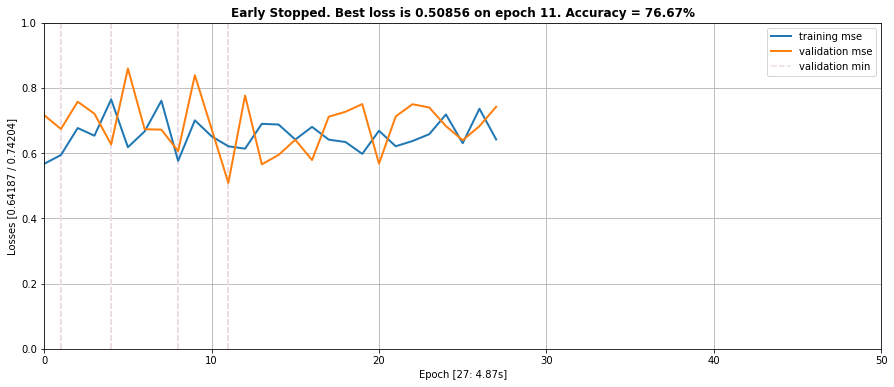

In [11]:
# Now, we will do a fine tune
train_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

train_generator.fit(X_train)


valid_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

valid_generator.fit(X_val)

batch_size = 200

fit_params = {
    'train_steps':     1500 / batch_size,
    'valid_steps':     500 / batch_size,
    'opt':             SGD(lr=0.0001, momentum=0.9, nesterov=True), 
    'loss':            'categorical_crossentropy', 
    'metrics':         ['accuracy'],
    'nepochs':         50, 
    'patience':        15,
    'ploss':           1.0,
    'reset':           True,
}


train_network_generator(model, model_name, train_generator.flow(X_train, y_train,batch_size=20), valid_generator.flow(X_val, y_val,batch_size=20), **fit_params);

In [12]:
# After fine tunning
loss, accuracy = model.evaluate(X_test,y_test)
print(loss)
print(accuracy)

500/500 [==============================] - 6s     
0.680029262066
0.685999999523


In [32]:
# Probabilidade
y_test_prob = model.predict(X_test, batch_size=32)

# Classes
y_test_hat = np.argmax(y_test_prob, axis=1)

print(y_test_hat[:30])
print(y_test_categorical[:30])


[0 0 0 2 1 1 1 2 1 0 1 2 1 0 0 0 0 0 0 0 0 2 1 0 1 1 2 0 0 1]
[0 0 2 2 1 2 1 2 1 2 1 2 1 2 0 0 1 0 0 0 0 0 2 0 1 1 2 0 0 1]


In [27]:
import pandas as pd
pd.crosstab(y_test_categorical, y_test_hat)

col_0,0,1,2
row_0,,,
0,113,22,38
1,21,144,8
2,48,20,86


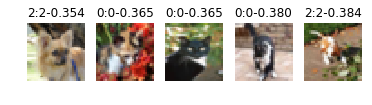

In [37]:
# Indices que tem classificação correta
correct_class_idx = np.where(y_test_categorical==y_test_hat)[0]

# indices com pior probabilidade
max_prob = y_test_prob.max(axis=1)
prob_correct = max_prob[correct_class_idx]
sorted_prob_idx = np.argsort(prob_correct)

# piores probabilidades entre as predições corretas
worst_5_idx = sorted_prob_idx[:5]

for k, i in enumerate(worst_5_idx):
    plot.subplot(1, 5, k + 1)
    plot.imshow(X_test[correct_class_idx[i]])
    plot.title('{}:{}-{:0.3f}'.format(y_test_categorical[correct_class_idx[i]],
                                     y_test_hat[correct_class_idx[i]],
                                     max_prob[correct_class_idx[i]]))
    plot.axis('off')
    
plot.savefig('cifar_fig.png')
plot.show()

cifar-10.history  my_cifar_dataplus.ipynb
cifar_fig.png     my_cifar_transferlearning.ipynb
